# Lesson 3: Building an Agent Reasoning Loop

Ref: [deeplearning.ai](https://learn.deeplearning.ai/courses/building-agentic-rag-with-llamaindex/lesson/ix5w5/building-an-agent-reasoning-loop)     
Login with email: ashok@fsm.ac.in (password is the usual one)    
   
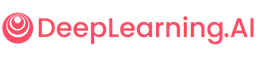


## Setup

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
# 1.0
import nest_asyncio
nest_asyncio.apply()

## Load the data

To download this paper, below is the needed code:

#!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O metagpt.pdf

**Note**: The pdf file is included with this lesson. To access it, go to the `File` menu and select`Open...`.

In [3]:
# 1.0
import nest_asyncio
nest_asyncio.apply()

In [14]:
# 2.0

from llama_index.core import Settings
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.openai_like import OpenAILike

# 2.1

Settings.llm = OpenAILike(
                          temperature=0.7,
                          model= "gpt-3.5-turbo",  # "gemma-3-27b-it",  #          # Can be any name, not necessarily openai's gpt
                          api_base="http://127.0.0.1:8080/v1",
                          api_key="fake",
                          timeout= 1000.0,
                          is_chat_model = True,
                          is_function_calling_model=True,
                          )

# 2.2
Settings.embed_model = OllamaEmbedding(
                                        model_name="nomic-embed-text",      # Using foundational model may be overkill
                                        base_url="http://localhost:11434",
                                       )


In [15]:
# 3.0

from llama_index.core import SimpleDirectoryReader

# 3.1 load documents
documents = SimpleDirectoryReader(input_files=["/home/ashok/Documents/csvrag/metagpt.pdf"]).load_data()

In [16]:
# 4.0

from llama_index.core.node_parser import SentenceSplitter

# 3.1
splitter = SentenceSplitter(chunk_size=1024)

# 3.2
nodes = splitter.get_nodes_from_documents(documents)

## Setup the Query Tools

In [17]:
# 5.0
from llama_index.core import SummaryIndex, VectorStoreIndex

# 5.0
summary_index = SummaryIndex(nodes)

# 5.1
vector_index = VectorStoreIndex(
                                 nodes,
                                 show_progres = True
                               )

In [18]:
# 6.0
summary_query_engine = summary_index.as_query_engine(
                                                     response_mode="tree_summarize",
                                                     use_async=True,  # Optional but gives faster response
                                                    )

# 6.1
vector_query_engine = vector_index.as_query_engine(show_progress = True)

In [19]:
# 7.0

from llama_index.core.tools import QueryEngineTool

# 7.1
summary_tool = QueryEngineTool.from_defaults(
                                             query_engine=summary_query_engine,
                                             description=(
                                                          "Useful for summarization questions related to MetaGPT"
                                                          ),
                                              )

# 7.2
vector_tool = QueryEngineTool.from_defaults(
                                             query_engine=vector_query_engine,
                                             description=(
                                                           "Useful for retrieving specific context from the MetaGPT paper."
                                                         ),
                                            )


In [20]:
#from utils import get_doc_tools

#vector_tool, summary_tool = get_doc_tools("metagpt.pdf", "metagpt")

## Setup Function Calling Agent

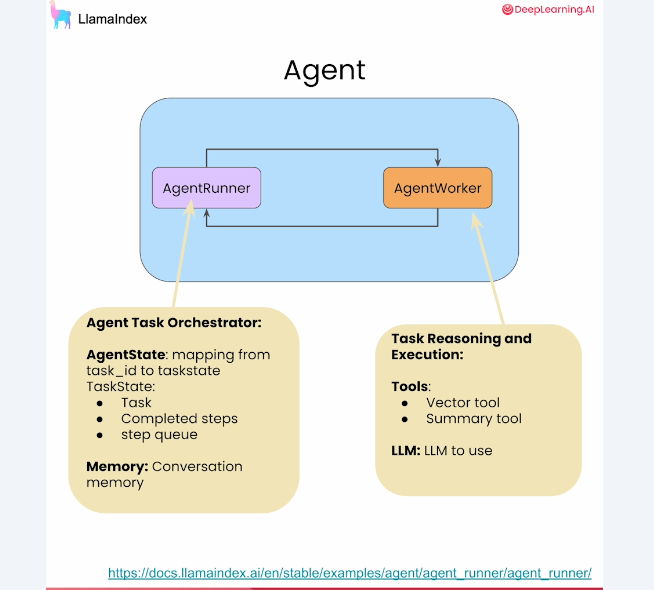

Another generic figure

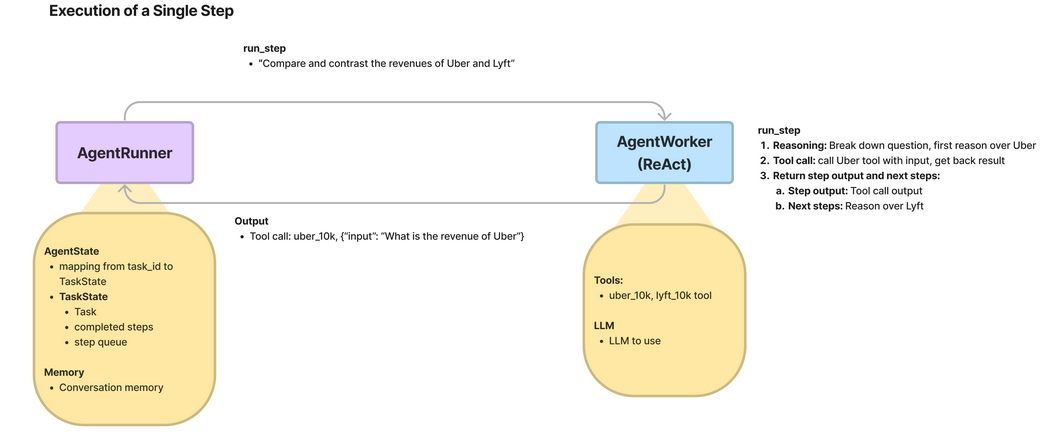

## What are Agent runner and Agen worker

In the context of LlamaIndex, an AgentRunner orchestrates the execution of tasks, managing state, and creating/running steps, while an AgentWorker controls the step-wise execution of a task, generating the next step based on the input and state. 
Here's a more detailed breakdown:

    AgentRunner:
        Orchestrator: The AgentRunner is the main orchestrator, responsible for managing the overall flow of an agent's execution.
        Task Management: It creates and maintains tasks, which are essentially high-level goals or queries provided by the user.
        State Management: It stores state (including conversational memory) and passes it to the AgentWorker.
        Step Execution: It calls the AgentWorker to execute steps within a task and collects/aggregates the results.
        User Interface: It provides the user-facing, high-level interface for users to interact with the agent. 
    AgentWorker:
        Step-wise Execution: The AgentWorker is responsible for controlling the step-wise execution of a task.
        Next Step Generation: It generates what the next step should be based on the input and the current state of the task.
        Task Execution: It takes a task and executes the steps within it, potentially using tools or other resources.
        Result Collection: It returns the output of each step to the AgentRunner. 

In essence: The AgentRunner acts as the conductor, while the AgentWorker is the musician, executing the steps in the task according to the AgentRunner's direction.

In [21]:
# 8.0
llm = Settings.llm

In [22]:
# 9.0

from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

# 9.1
agent_worker = FunctionCallingAgentWorker.from_tools(
                                                      [vector_tool, summary_tool], 
                                                      llm=llm, 
                                                      verbose=True
                                                    )

# 9.2
agent = AgentRunner(agent_worker)

In [23]:
%%time

# 10.0
response = agent.query(
    "Tell me about the agent roles in MetaGPT, "
    "and then how they communicate with each other."
)

Added user message to memory: Tell me about the agent roles in MetaGPT, and then how they communicate with each other.
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "Tell me about the agent roles in MetaGPT, and then how they communicate with each other."}
=== Function Output ===
In MetaGPT, the agent roles are specifically designed to enhance the efficiency and effectiveness of software development tasks. The primary roles include the Product Manager, Architect, Project Manager, Engineer, and QA Engineer, each with distinct responsibilities:

1. **Product Manager**: This agent is responsible for conducting business-oriented analysis and deriving insights. They create a Product Requirement Document (PRD) that includes goals, user stories, competitive analysis, and requirement analysis. This document serves as the foundation for the project and is handed over to the Architect for further development.

2. **Architect**: The Architect takes the PRD and 

In [24]:
# 10.1
print(response.source_nodes[0].get_content(metadata_mode="all"))

page_label: 1
file_name: metagpt.pdf
file_path: /home/ashok/Documents/csvrag/metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2025-03-21
last_modified_date: 2025-03-20

Preprint
METAGPT: M ETA PROGRAMMING FOR A
MULTI -AGENT COLLABORATIVE FRAMEWORK
Sirui Hong1∗, Mingchen Zhuge2∗, Jonathan Chen1, Xiawu Zheng3, Yuheng Cheng4,
Ceyao Zhang4, Jinlin Wang1, Zili Wang, Steven Ka Shing Yau5, Zijuan Lin4,
Liyang Zhou6, Chenyu Ran1, Lingfeng Xiao1,7, Chenglin Wu1†, J¨urgen Schmidhuber2,8
1DeepWisdom, 2AI Initiative, King Abdullah University of Science and Technology,
3Xiamen University, 4The Chinese University of Hong Kong, Shenzhen,
5Nanjing University, 6University of Pennsylvania,
7University of California, Berkeley, 8The Swiss AI Lab IDSIA/USI/SUPSI
ABSTRACT
Remarkable progress has been made on automated problem solving through so-
cieties of agents based on large language models (LLMs). Existing LLM-based
multi-agent systems can already solve simple dialogue tasks. So

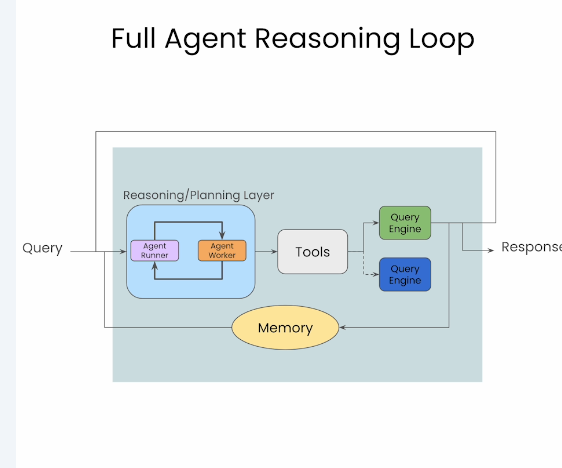

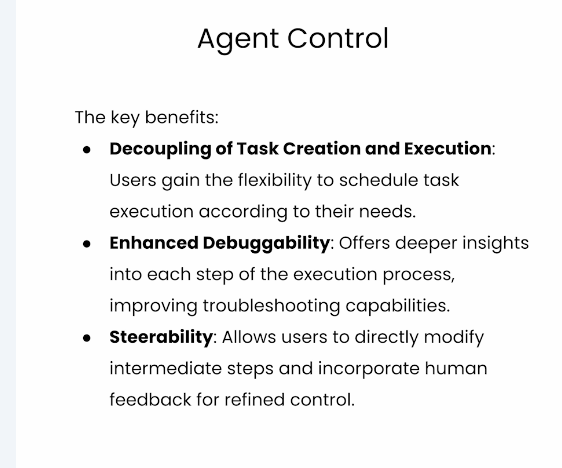

In [ ]:
#10.2

response = agent.chat(
                       "Tell me about the evaluation datasets used."
                     )

In [ ]:
# 10.3

response = agent.chat("Tell me the results over one of the above datasets.")

## Lower-Level: Debuggability and Control

In [ ]:
agent_worker = FunctionCallingAgentWorker.from_tools(
                                                      [vector_tool, summary_tool], 
                                                       llm=llm, 
                                                       verbose=True
                                                    )

agent = AgentRunner(agent_worker)

In [ ]:

task = agent.create_task(
                         "Tell me about the agent roles in MetaGPT, "
                         "and then how they communicate with each other."
                        )

In [ ]:
step_output = agent.run_step(task.task_id)

In [ ]:
completed_steps = agent.get_completed_steps(task.task_id)

print(f"Num completed for task {task.task_id}: {len(completed_steps)}")
print(completed_steps[0].output.sources[0].raw_output)

In [ ]:
upcoming_steps = agent.get_upcoming_steps(task.task_id)

print(f"Num upcoming steps for task {task.task_id}: {len(upcoming_steps)}")
upcoming_steps[0]

In [ ]:
step_output = agent.run_step(
                              task.task_id, input="What about how agents share information?"
                            )

In [ ]:
step_output = agent.run_step(task.task_id)
print(step_output.is_last)

In [ ]:
response = agent.finalize_response(task.task_id)

In [ ]:
print(str(response))